# Introduction to python for climate science

**Content creator:** Ligin Joseph

#### In this session, we will use xarray to:
- Open a netcdf file
- Convert daily data to JJAS
- Plot time series
- Plot spatial maps

In [88]:
#Imports

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean
import cartopy.feature as cfeatures
from scipy import stats

In [2]:
#Open a netcdf file
ds = xr.open_dataset('../PHD_materials/Data/Observations/IMD/IMD_1d_1951_2023.nc') 
ds

C:\Users\li3n23\miniforge3\envs\Work\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'rasterio' loading failed:
module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset>
Dimensions:    (LONGITUDE: 135, LATITUDE: 129, TIME: 26663)
Coordinates:
  * LONGITUDE  (LONGITUDE) float64 66.5 66.75 67.0 67.25 ... 99.5 99.75 100.0
  * LATITUDE   (LATITUDE) float64 6.5 6.75 7.0 7.25 ... 37.75 38.0 38.25 38.5
  * TIME       (TIME) datetime64[ns] 1951-01-01 1951-01-02 ... 2023-12-31
Data variables:
    RAINFALL   (TIME, LATITUDE, LONGITUDE) float64 ...
Attributes:
    history:      FERRET V7.5 (optimized) 20-Jan-23
    Conventions:  CF-1.6

This dataset contains a three-dimensional variable named RAINFALL. We can subset the dataset by using [.sel()](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.sel.html). For example 

In [7]:
## Select the data for 01/01/2000
ds_2000 = ds.sel(TIME='2000-01-01',method='nearest')
ds_2000

<xarray.Dataset>
Dimensions:    (LONGITUDE: 135, LATITUDE: 129)
Coordinates:
  * LONGITUDE  (LONGITUDE) float64 66.5 66.75 67.0 67.25 ... 99.5 99.75 100.0
  * LATITUDE   (LATITUDE) float64 6.5 6.75 7.0 7.25 ... 37.75 38.0 38.25 38.5
    TIME       datetime64[ns] 2000-01-01
Data variables:
    RAINFALL   (LATITUDE, LONGITUDE) float64 ...
Attributes:
    history:      FERRET V7.5 (optimized) 20-Jan-23
    Conventions:  CF-1.6

In [9]:
## We can also select a range of data using slice.
#For example, to select the data between 2000 and 2010, we can use
ds_2000_2010 = ds.sel(TIME=slice('2000','2010'))
ds_2000_2010

<xarray.Dataset>
Dimensions:    (LONGITUDE: 135, LATITUDE: 129, TIME: 4018)
Coordinates:
  * LONGITUDE  (LONGITUDE) float64 66.5 66.75 67.0 67.25 ... 99.5 99.75 100.0
  * LATITUDE   (LATITUDE) float64 6.5 6.75 7.0 7.25 ... 37.75 38.0 38.25 38.5
  * TIME       (TIME) datetime64[ns] 2000-01-01 2000-01-02 ... 2010-12-31
Data variables:
    RAINFALL   (TIME, LATITUDE, LONGITUDE) float64 ...
Attributes:
    history:      FERRET V7.5 (optimized) 20-Jan-23
    Conventions:  CF-1.6

Now we can combine [.sel()](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.sel.html) and [.isin()](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.isin.html) to extract the JJAS values.

In [91]:
ds_JJAS = ds.sel(TIME=ds['TIME.month'].isin([6, 7, 8, 9]))
ds_JJAS

<xarray.Dataset>
Dimensions:    (LONGITUDE: 135, LATITUDE: 129, TIME: 8906)
Coordinates:
  * LONGITUDE  (LONGITUDE) float64 66.5 66.75 67.0 67.25 ... 99.5 99.75 100.0
  * LATITUDE   (LATITUDE) float64 6.5 6.75 7.0 7.25 ... 37.75 38.0 38.25 38.5
  * TIME       (TIME) datetime64[ns] 1951-06-01 1951-06-02 ... 2023-09-30
Data variables:
    RAINFALL   (TIME, LATITUDE, LONGITUDE) float64 ...
Attributes:
    history:      FERRET V7.5 (optimized) 20-Jan-23
    Conventions:  CF-1.6

We now need to convert this daily data to JJAS mean or sum using [.groupby()](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.groupby.html).

In [27]:
ds_JJAS_yr = ds_JJAS.groupby('TIME.year').mean('TIME') # or .sum()
ds_JJAS_yr

<xarray.Dataset>
Dimensions:    (LONGITUDE: 135, LATITUDE: 129, year: 73)
Coordinates:
  * LONGITUDE  (LONGITUDE) float64 66.5 66.75 67.0 67.25 ... 99.5 99.75 100.0
  * LATITUDE   (LATITUDE) float64 6.5 6.75 7.0 7.25 ... 37.75 38.0 38.25 38.5
  * year       (year) int64 1951 1952 1953 1954 1955 ... 2020 2021 2022 2023
Data variables:
    RAINFALL   (year, LATITUDE, LONGITUDE) float64 nan nan nan ... nan nan nan
Attributes:
    history:      FERRET V7.5 (optimized) 20-Jan-23
    Conventions:  CF-1.6

We can compute the spatial mean using [.mean()](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.mean.html)

In [29]:
# Since we need to calculate the mean over multiple dimensions (LATITUDE and LONGITUDE),
# we can specify the dimensions in a list 
ISMR = ds_JJAS_yr.mean(['LATITUDE','LONGITUDE'])
ISMR

<xarray.Dataset>
Dimensions:   (year: 73)
Coordinates:
  * year      (year) int64 1951 1952 1953 1954 1955 ... 2019 2020 2021 2022 2023
Data variables:
    RAINFALL  (year) float64 5.819 6.554 7.491 7.272 ... 7.844 7.093 7.54 6.65

Now we can plot the time series using [.plot()](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.plot.html)

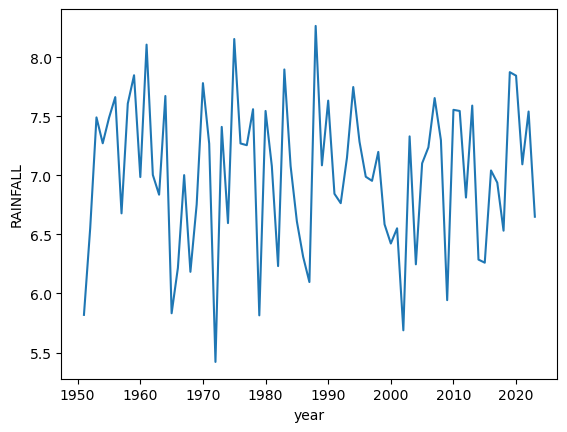

In [36]:
ISMR.RAINFALL.plot()

We can beautify this plot by providing some extra arguments

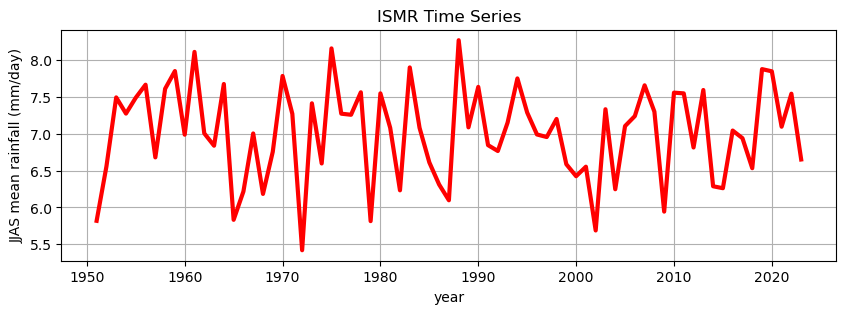

In [53]:
ISMR.RAINFALL.plot(figsize=(10,3),linewidth=3,color='red')
plt.title('ISMR Time Series')
plt.ylabel('JJAS mean rainfall (mm/day)')
plt.grid(True)

Lets compute and plot trend using [.linregress()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html) from scipy.stats

In [69]:
## stats.linregress(x_values,y_values) will return slope, intersept, p_value etc
slope_ISMR,intercept_ISMR, r_value, p_value, std_err = stats.linregress(ISMR.year, ISMR.RAINFALL)
## Trend line can be computed using trend = slope*x_values + intersept
trend_ISMR = slope_ISMR * ds_JJAS_yr.year + intercept_ISMR

Lets also plot the trend line with the time series

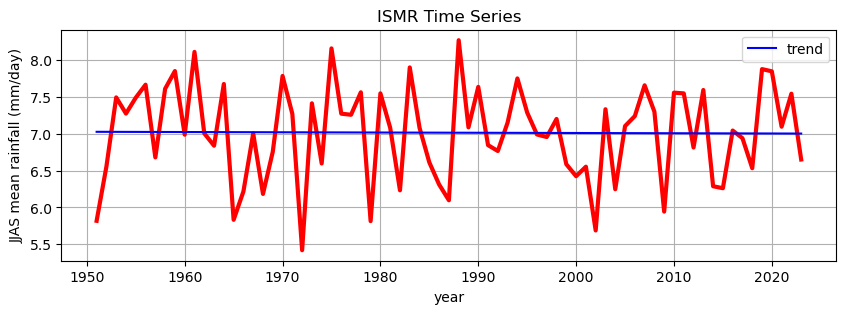

In [73]:
ISMR.RAINFALL.plot(figsize=(10,3),linewidth=3,color='red')
trend_ISMR.plot(color='blue',label='trend')
plt.title('ISMR Time Series')
plt.ylabel('JJAS mean rainfall (mm/day)')
plt.legend()
plt.grid(True)

In [74]:
# We can check whether the trend is statistically significant by printing the p_value

p_value

0.9272242100422444

Now we can compute the temporal mean of JJAS rainfall using [.mean()](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.mean.html).

In [48]:
precip_mean = ds_JJAS_yr.mean('year')
precip_mean

<xarray.Dataset>
Dimensions:    (LONGITUDE: 135, LATITUDE: 129)
Coordinates:
  * LONGITUDE  (LONGITUDE) float64 66.5 66.75 67.0 67.25 ... 99.5 99.75 100.0
  * LATITUDE   (LATITUDE) float64 6.5 6.75 7.0 7.25 ... 37.75 38.0 38.25 38.5
Data variables:
    RAINFALL   (LATITUDE, LONGITUDE) float64 nan nan nan nan ... nan nan nan nan

We can plot the JJAS mean precipitation by using [.plot()](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.plot.html)

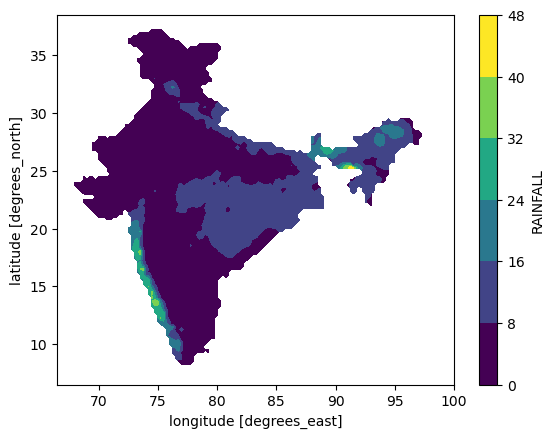

In [68]:
precip_mean.RAINFALL.plot.contourf()

We can beautiful this plot using [cartopy](https://scitools.org.uk/cartopy/docs/latest/getting_started/index.html)

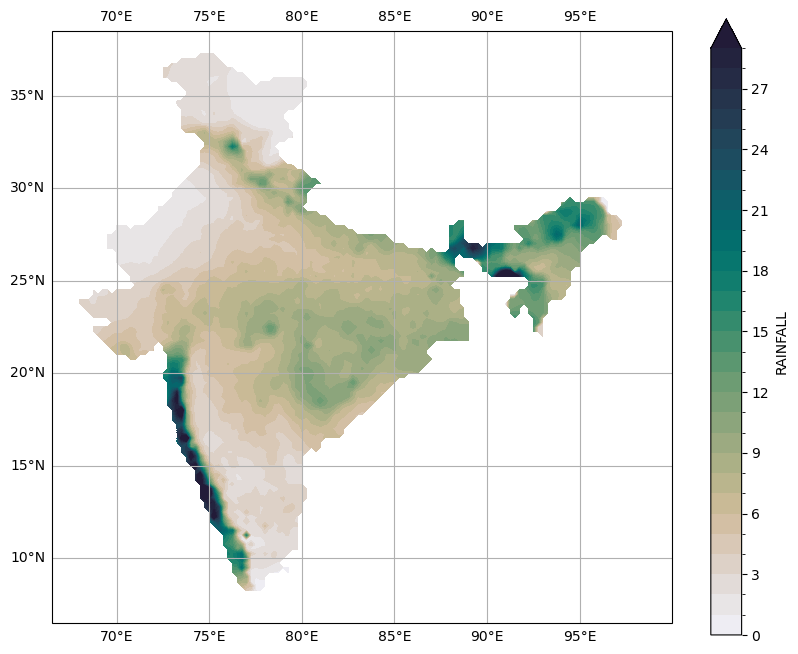

In [67]:
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())
precip_mean.RAINFALL.plot.contourf(ax=ax,cmap='cmo.rain',levels=np.arange(0,30,1))
g = ax.gridlines(draw_labels=True)
g.right_labels=False